In [352]:
# import libraries
import pandas as pd
import numpy as np
import os

from math import exp

from yahooquery import Ticker

In [70]:
data_dir = './data/'

print("In {} found:".format(data_dir))
print(os.listdir(data_dir))
select_csv1 = os.listdir(data_dir)[1]
select_csv2 = os.listdir(data_dir)[0]
print("Load {}".format(select_csv1))
print("Load {}".format(select_csv2))

In ./data/ found:
['df_time_20200804-230604_idxbatch_1633.csv', 'df_time_20200804-095041_idxbatch_1632.csv', 'googletrends.csv', 'firm_names.csv', 'topics.csv', '.ipynb_checkpoints']
Load df_time_20200804-095041_idxbatch_1632.csv
Load df_time_20200804-230604_idxbatch_1633.csv


In [189]:
## load basic data
# ESG topics
topics = list(pd.read_csv(data_dir+'topics.csv')['0'])

# googletrends data
df_raw1 = pd.read_csv(data_dir+select_csv1, header=None)
df_raw2 = pd.read_csv(data_dir+select_csv2, header='infer', index_col=0)

# rename columns
colnames = topics.copy()
colnames.append('firm')

df_raw1.columns = colnames
df_raw2.columns = colnames

df_raw = pd.concat([df_raw1, df_raw2], axis='index')
df_raw.head()

,scandal,greenwashing,corruption,fraud,bribe,tax,forced,harassment,violation,human rights,...,intransparent,data privacy,lawsuit,unfair,bad,problem,hate,issues,controversial,firm
0,0.0,0.0,0.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,32.0,13.0,0.0,13.0,0.0,3M
1,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,3M
2,0.0,0.0,0.0,0.0,0.0,72.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,3M
3,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,24.0,0.0,0.0,0.0,3M
4,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,37.0,0.0,0.0,0.0,0.0,3M


# Feature engineering and data transformation

In [176]:
# transform dataframe to obtain wide format
df_t = df_raw.copy()

# drop firm if duplicate (firm count > 261)
df_t = df_t.groupby('firm').head(260)

## collapse time dimension into n intervals
# df long --> df wide 
n_intervals = 5 #SET number of intervals to aggregate time dimension
n_periods = df_t.groupby('firm').firm.count()[0]
interval_size = int(n_periods/n_intervals)
n_unique_firms = len(df_t.firm.unique())

print("Collapse time dimension from {} observation periods to {} intervals, where an interval spans {} weeks."\
      .format(n_periods, n_intervals, interval_size))

# create intervals
intervals = np.tile(np.repeat(np.arange(n_intervals), interval_size), n_unique_firms)

df_t['t'] = intervals

Collapse time dimension from 260 observation periods to 5 intervals, where an interval spans 52 weeks.


In [391]:
## transform df long --> wide
# calculate means for each time interval t and firm
df_t_means = df_t.groupby(['firm', 't']).mean().reset_index()

# long format
df_t_long = pd.melt(df_t_means, id_vars=['firm', 't'], value_vars=topics[:-1]).reset_index(drop=True)

# # apply exponential decay function (more recent - higher weight)
df_t_long['value'] = df_t_long.value/df_t_long.t.apply(lambda x: exp(4-x))
print("Add exponential decay factor, assigning the highest weight to the {}th period ".format(4))

# long --> wide
df_t_wide = df_t_long.pivot_table(index=['firm'], columns=['t','variable'], values='value')

# rename columns
df_t_wide.columns = [s2 + '_' +str(s1) for (s1,s2) in df_t_wide.columns.tolist()]
df_t_wide.reset_index(inplace=True)

# set firms as index 
df_t_wide.set_index('firm', inplace=True)

Add exponential decay factor, assigning the highest weight to the 4th period 


In [392]:
df_t_wide.head()

,CO2_0,arms trade_0,bad_0,bribe_0,conflict_0,corruption_0,data privacy_0,discrimination_0,emission_0,forced_0,...,lawsuit_4,pollution_4,problem_4,racist_4,scandal_4,sexism_4,tax_4,unfair_4,violation_4,weapons_4
firm,,,,,,,,,,,,,,,,,,,,,
3M,0.04755,0.0,0.319115,0.0,0.0,0.0,0.0,0.0,0.129266,0.084886,...,46.384615,17.288462,11.038462,0.461538,10.192308,0.0,38.307692,0.0,0.0,0.865385
A.O. Smith,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
ABIOMED,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
AES,0.00000,0.0,0.477968,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,23.480769,0.000000,0.000000,0.0,16.826923,0.0,0.0,0.000000
AFLAC,0.00000,0.0,0.335317,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,28.865385,0.0,0.0,0.000000


# Outcome: ESG score from Yahoo! finance
## load S&P 500 and select firm subset 

In [393]:
# retrieve S&P 500 listings from Wikipedia
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df_sp500 = table[0]

# map ticker (Symbol) to firm_names used in search queries
df_sp500['custom_name'] = firm_names

# select only firms that occur in google trends df (df_t_wide)
df_subset_sp500 = df_sp500[df_sp500.custom_name.isin(list(df_t_wide.index))]

## Get ESG scores 

In [394]:
# select Ticker (firm acronyms = symbols)
ticker = list(df_subset_sp500.Symbol)

# retrieve ESG scores
# init yahoo ticker
tickers = Ticker(ticker)

# obtain ESG data (Yahoo x Sustainalytics)
esg_data = tickers.esg_scores
df_esg_raw = pd.DataFrame(esg_data)

def df_to_numeric(ds):
    """Converts columns to numeric where possible"""
    try: 
        return pd.to_numeric(ds)
    except:
        return ds

## wrangle dataframe
# replace strings missings with np.nan and bools with 0 or 1
# transform s.t. each row represents a firm 
# convert columns to numeric, where feasible
df_esg = df_esg_raw.replace({'No fundamentals data found for any of the summaryTypes=esgScores': np.nan,
                            False: 0, 
                            True: 1})\
                    .T\
                    .apply(df_to_numeric)

# store tickers for missing ESG info 
ticker_missing_esg = df_esg[df_esg.isnull().any(axis=1) == True].index

# drop missings
df_esg.dropna(inplace=True)

print("Dropped {}".format(drop_pre-drop_post))
print(df_esg.iloc[:,1:5].head())

# main outcome, y:total ESG score 
y = df_esg.totalEsg.values

# deselect missing ESG firm data from S&P500
df_subset_sp500_nomiss = df_subset_sp500[~df_subset_sp500.Symbol.isin(ticker_missing_esg)]

# Merge ESG scores on custom_name and index
df_subset_sp500_nomiss['y'] = y

Dropped 53
      totalEsg  environmentScore  socialScore  governanceScore
MMM      34.75             12.79        13.89             8.07
ABT      29.83              2.98        16.21            10.63
ABBV     30.19              0.96        16.53            12.69
ACN      11.24              0.55         4.98             5.71
ATVI     16.71              0.15        10.46             6.09


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [395]:
def make_csv(x, filename, data_dir, append=False, header=False, index=False):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    
    # create dir if nonexistent
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    # make sure its a df
    x = pd.DataFrame(x)
    
    # export to csv
    if not append:
        x.to_csv(os.path.join(data_dir, filename), 
                                     header=header, 
                                     index=index)
    else:
        x.to_csv(os.path.join(data_dir, filename),
                                     mode = 'a',
                                     header=header, 
                                     index=index)        
    
    # nothing is returned, but a print statement indicates that the function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))

In [396]:
# prepare for merge with df_t_wide
df_tomerge = df_subset_sp500_nomiss[['custom_name', 'y']]
# set same index as df_t_wide
df_tomerge = df_tomerge.rename(columns={'custom_name':'firm'}).set_index('firm')
# subset df_t_wide on firms with ESG score
df_t_wide_tomerge = df_t_wide[df_t_wide.index.isin(df_tomerge.index)]

# merge df
df = pd.concat([df_tomerge, df_t_wide_tomerge], axis=1)

## store data as csv
# get timestamp
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
df_filename = 'df_{}.csv'.format(timestr)

make_csv(df, df_filename, 'data', header=True, index=True)

Path created: data/df_20200805-050644.csv


# What the data is about

* Google trends (https://trends.google.com/trends/?geo=US) shows search interest for a given keyword within a specified region. 
* As a starting point, I deal with American firms and thus focus on the US using English keywords. 
* The Google trend indicator quantifies the relative search volume of searches between two or more terms. Hence, 
* Relative search volume could be interpreted as search interest and ranges from 0 to 100. To be clear, it lacks a defined measurement unit such as an absolute search count, but relates to all other keywords that were part of the query to Google trends. Therefore, it is crucial to have search keywords that (TODO)
* A popular procedure to select ESG investments is by checking on whether a firm fulfils defined exclusion criteria, which is termed negative screening. For example, if a firm engages in  arms trade, it would be excluded from ESG portfolios. Some other examples are firms  linked to corruption, relying on fossil fuels or notorious for avoiding taxes. 
* On the opposite, another ESG investment approach would be positive screening, where a person selects firms since they rely on renewables, promote gender equality or score high in transparency.
* I constructed 30 keywords based on negative screening, since issues about a particular firm likely appear in the news and are therefore more salient to the public than a corporate social responsiblity project mentioned in a sustainability report. I chose them in a way to cover a broad range of relevant topics for negative screening and derived them in part from negating UN's sustainable development goals (https://www.un.org/sustainabledevelopment/sustainable-development-goals/). Additionally, I included general keywords that people will search for, when they suspect a firm acting against their morale, such as "firm xy issues" or "firm xy bad". Keywords like "scandal" or "lawsuit" will possibly cover a lot of specific terminology used by ESG investors for negative screening, but are assumed to be more common among individuals. 
* The overarching themes within my keywords inlcude ecological impact, gender equality, activities against law, negative news coverage, negative public image and weapons. 
* All in all, I composed 30 keywords to capture a broad range of negative screening criteria and included the following keywords:
    * *'scandal', 'greenwashing', 'corruption', 'fraud', 'bribe', 'tax', 'forced', 'harassment', 'violation', 'human rights', 'conflict', 'weapons', 'arms trade', 'pollution', 'CO2', 'emission', 'fossil fuel','gender inequality', 'discrimination', 'sexism', 'racist', 'intransparent', 'data privacy', 'lawsuit', 'unfair', 'bad', 'problem', 'hate', 'issues', 'controversial'*
          
* The topical keywords need to be merged with firm names to end up with keywords that are passed to Google trends. To achieve this, I merge the topic keywords with firm names and get topic-firm pairwise combinations, such as 
    * *'scandal 3M ', 'greenwashing 3M ', 'corruption 3M ', 'fraud 3M 'or 'bribe 3M '*.

* To access data from Google trends and establish a connection, the project relies on the Pytrends API (https://pypi.org/project/pytrends/). 
* Several issues arise from gathering data with Google trends. Firstly, Google trends allows a maximum of five keywords per query. Secondly, a rate limit exists which protects Google's servers from too many requests. Thirdly, the metric of search interest is scaled based on the search interest of the keyword with the most searches as compared to other keywords. 
* The query limit requires a simple workaround, where I need to batch keywords and subsequently pass each keyword batch to Google trends. With $500$ firms, $30$ keywords and a batch size of $5$, there are $500 \times 30\times \frac{1}{5}=3000$ queries. 
* The rate limit calls for a timeout. Since Google does not publish information about their search backend due to secutiry reasons, the exact rate limit is unknown. But, query errors lead to missing data entries, which leads to fewer data points to train, validate or test the model. Therefore, I favor a conservative approach, setting the timeout to 20 seconds. The downside of this are runtimes of $3000 \times 20 $ seconds $= 60.000$ seconds $\approx 16.7$ hours. A distinct jupyter notebook that exectutes queries in the background and stores query responses in a csv in case of error response, frees up coding capacity for model setup and avoids data loss caused by rate limits. 
* The last challenge with Google trends is the relative search metric. To exemplify this, a query of three words with ['pizza', 'president', 'covid'] scales the search interest to the keyword with the most number of searches. The images below illustrate this. It would be a cause of concern when keywords belong to distinct informational sets. Nevertheless, the constructed keywords have the firm name in common, which makes outliers in search interest across queries unlikely since they have the firm name in common. To be concice, I assume that the firm name sufficiently conncets keywords and thereby reduces outliers caused by the relative metric.  

# Transform dataframe
 
* To feed the data into the model, it has to meet certain criteria. A simple data format has rows for individuals and columns for an individual's characteristics. In this example, it should be a matrix where one row stands for one firm and where columns contain information about the firm. 

* However, Google trends returns a time-series for each keyword spanning the last five years, reported weekly. This amounts to $260$ ($52$ weeks  $\times$ $5$ years  $= 260$) entries for each keyword and yields the so-called "long" data format for a given firm, A and 30 search keyword:

Firm|time|keyword_1|...|keyword_30
---|---|---|---|---|
A | 1 | 25 | ...| 30
A | 2 | 25 | ...| 30
... | ... | ... | ...| ...
A | 260 | 25 | ...| 30

* Thus, the data needs to be re-shaped into a wide format as previously described. 
* Ideally, re-shaping does not imply information loss. Nevertheless, weekly data might be too granular for the prediction task and likely does not add valuable information as compared to year averages. Thus, taking yearly averages is assumed to have sufficient information about a topic. Peaks in search volume are mirrored by higher year averages instead of week-to-week differences.
* Averaging by year, adding the time dimension to keywords variables and thereby collapsing the time dimension, yields the wide format. The following table illustrates the desired wide format, which can be fed into the model: 

Firm|keyword_1_t1|keyword_1_t2|...|keyword_30_t5
---|---|---|---|---|
A | 0 | 2 | ...| 50
B | 3 | 25 | ...| 77
... | ... | ... | ...| ...
Z | 14 | 60 | ...| 42



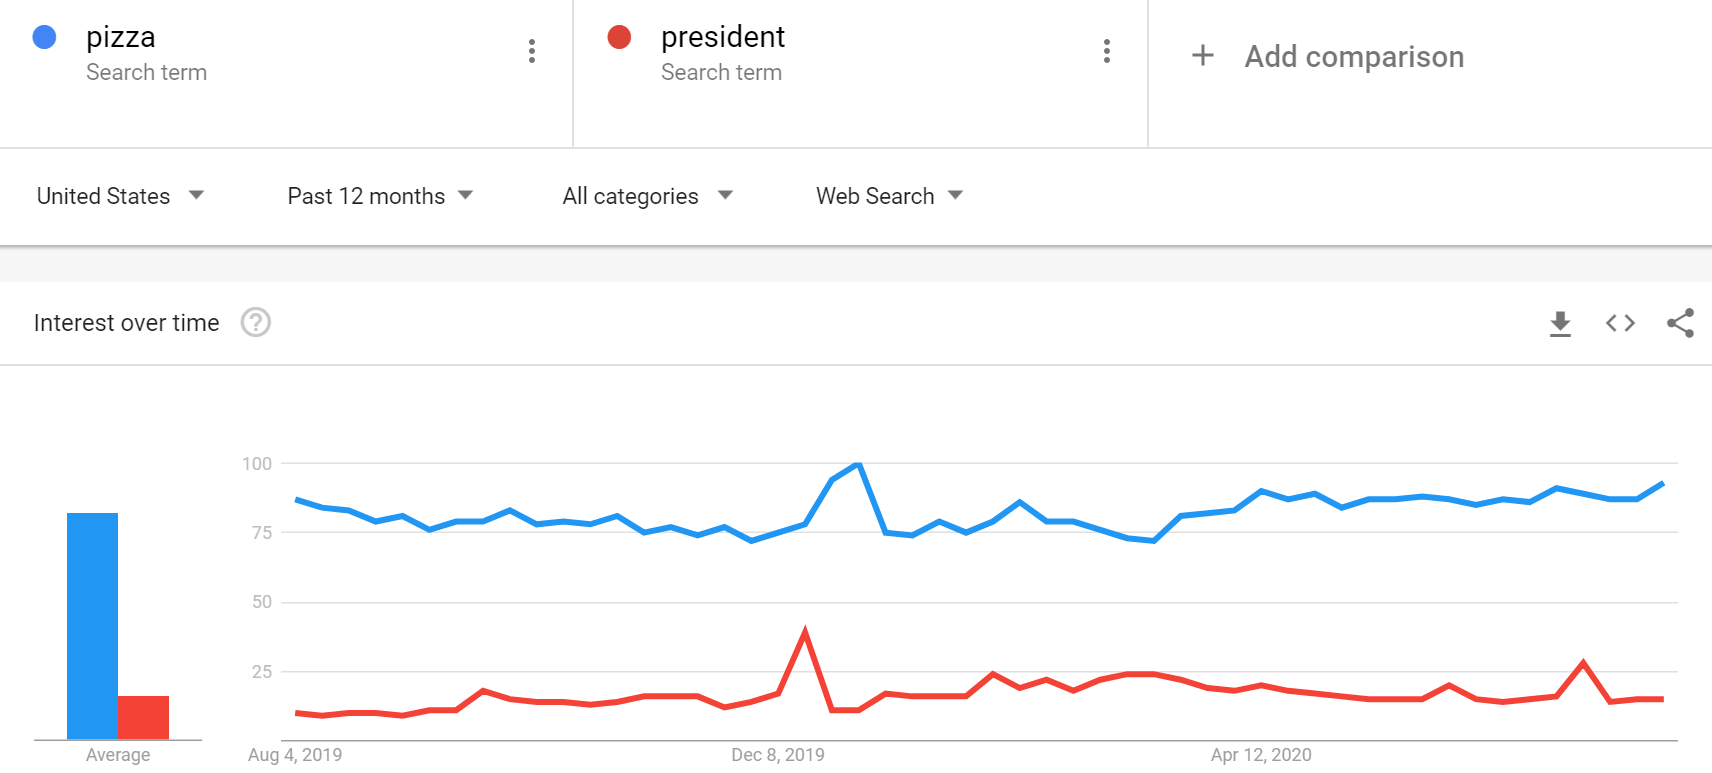

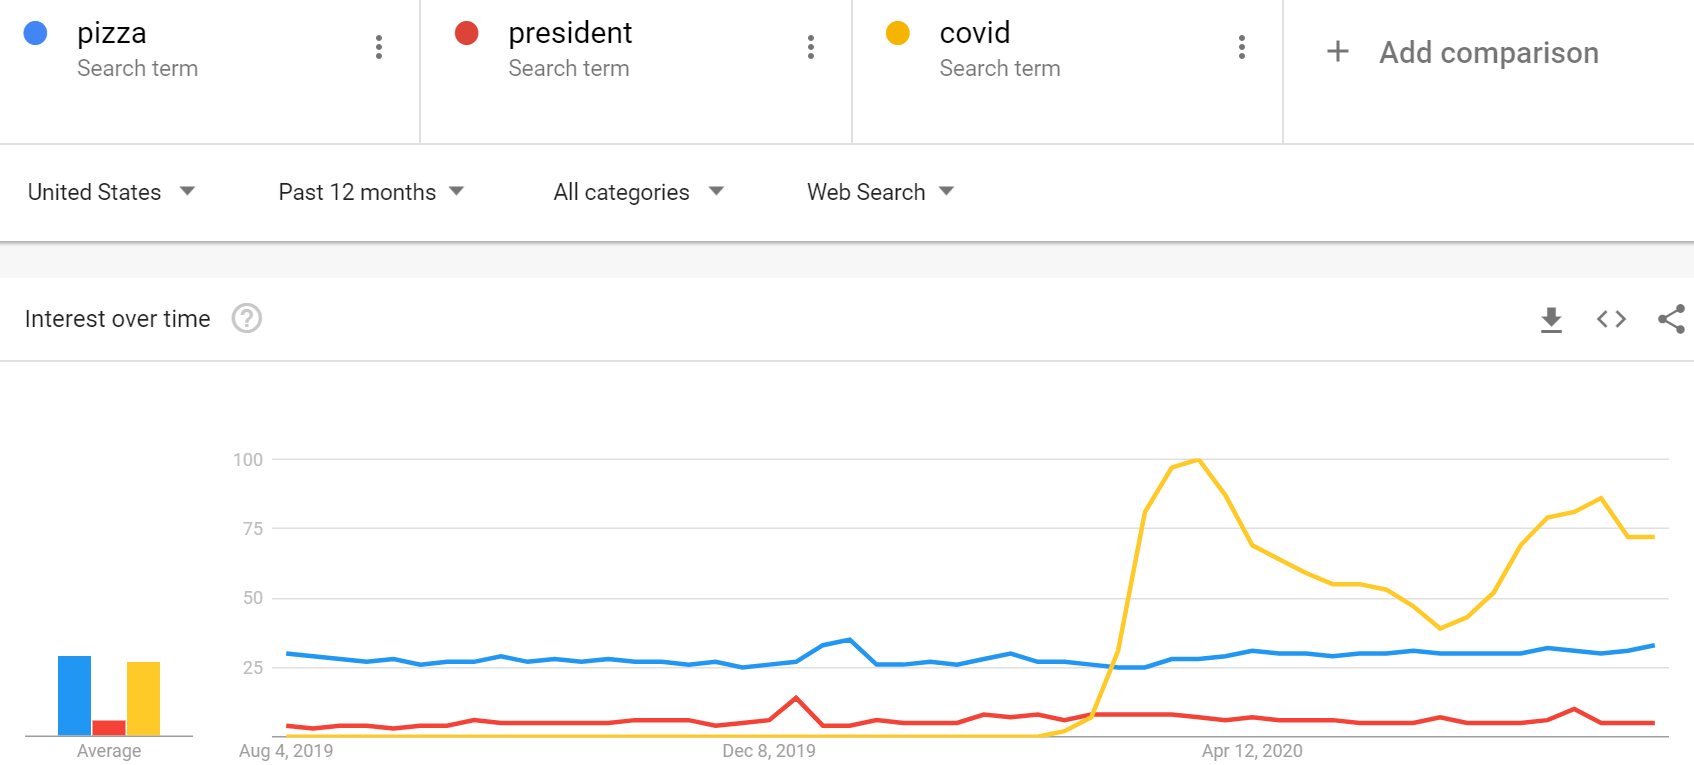

# Load & explore the data

In [462]:
# navigate dir
data_dir = './data/'
filename = 'df_20200805-050644.csv'

# googletrends data
df = pd.read_csv(data_dir+filename, index_col=0).dropna()

# define ESG class based on median split: low scores = 0, high scores = 1
df['y_class'] = (df['y'] >= df.y.median())*1
print(df.shape)

# define X and y
X = df.iloc[:,1:-1]
y = df.loc[:,'y_class']



df.head()

(305, 147)


,y,CO2_0,arms trade_0,bad_0,bribe_0,conflict_0,corruption_0,data privacy_0,discrimination_0,emission_0,...,pollution_4,problem_4,racist_4,scandal_4,sexism_4,tax_4,unfair_4,violation_4,weapons_4,y_class
3M,34.75,0.04755,0.0,0.319115,0.0,0.0,0.0,0.0,0.0,0.129266,...,17.288462,11.038462,0.461538,10.192308,0.0,38.307692,0.0,0.0,0.865385,1
Abbott Laboratories,29.83,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1
AbbVie,30.19,0.00000,0.0,0.178577,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,29.076923,0.0,0.0,0.000000,1
Accenture,11.24,0.00000,0.0,0.448029,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,16.750000,0.000000,6.596154,0.0,34.769231,0.0,0.0,0.000000,0
Activision Blizzard,16.71,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0


## Dataframe description
The dataset is a $N\times(M+1)$ matrix which contains overall $N=305$ rows, $i$, with $M=145$ features, $X_m$, and one outcome variable, $y$. The $145$ features, $X_m$, indicate year-average search interest for a keyword-firm combination at time $t$, which spans five years, indicated by the variable suffixes _$0$ to _$4$. 
The outcome variable, $y$, is a firm's overall ESG score. 
Thus, all metrics count as a ordinal attribute types, because they are ordered, but the relative magnitude of a variable has no physical meaning. ESG scores rank firms relatively within sector, so that a one point difference for one firm does not mean the same for another. The same holds for relative search interest for a given keyword-firm pair. 

## Descriptives

In [400]:
#sklearn modules
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#plots
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

### Features: Means and maximum values

In [456]:
# variable means (most recent period)
means = df.iloc[:,-29:-1].describe().loc['mean',:].sort_values(ascending=False)
maxima = df.iloc[:,-29:-1].describe().loc['max',:].sort_values(ascending=False)

print("Variable means: top-5 highest and lowest")
print("Variable | mean")
print("---|---|")
print(means.head())
print("-"*40)
print(means.tail())
print('='*50)

print("Variable maxima: top-5 highest and lowest")
print("Variable | mean")
print("---|---|")
print(maxima.head())
print("---|---|")
print(maxima.tail())

Variable means: top-5 highest and lowest
Variable | mean
---|---|
tax_4        14.731021
bad_4        13.299369
problem_4     4.437894
issues_4      4.334615
fraud_4       4.154477
Name: mean, dtype: float64
----------------------------------------
harassment_4       0.103090
bribe_4            0.001955
greenwashing_4     0.000000
intransparent_4    0.000000
arms trade_4       0.000000
Name: mean, dtype: float64
Variable maxima: top-5 highest and lowest
Variable | mean
---|---|
bad_4          76.403846
tax_4          63.961538
fraud_4        62.038462
pollution_4    56.692308
problem_4      50.057692
Name: max, dtype: float64
---|---|
harassment_4       4.403846
bribe_4            0.346154
greenwashing_4     0.000000
intransparent_4    0.000000
arms trade_4       0.000000
Name: max, dtype: float64


### Outcome: Mean and maximum

In [386]:
# variable means (most recent period)
df.y.describe()

count    305.000000
mean      23.904918
std        7.716503
min        8.640000
25%       18.120000
50%       23.190000
75%       28.860000
max       51.700000
Name: y, dtype: float64

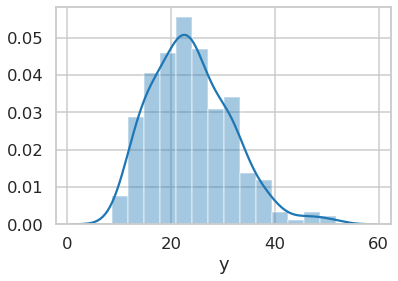

In [409]:
sns.distplot(df.y)

## Variable means

I focus on the most recent period, corresponding to the time window from today to 1 year ago. The variables have suffix _$4$ and were not down-weighted by the decay function, which means we see the unprocessed metric for search interest. Looking at top-five highest and lowest variable means yields the following tables.

Variable | mean (5 highest)
---|---|
tax_4       | 14.731021
bad_4       | 13.299369
problem_4    | 4.437894
issues_4     | 4.334615
fraud_4      | 4.154477
---------- | **(5 lowest)** |
harassment_4     |  0.103090
bribe_4          |  0.001955
greenwashing_4   |  0.000000
intransparent_4  |  0.000000
arms trade_4     |  0.000000


(TODO: describe means)



Variable | maximum (5 highest)
---|---|
bad_4     |     76.403846
tax_4      |    63.961538
fraud_4     |   62.038462
CO2_4        |  60.961538
pollution_4   | 56.692308
 ---------- | **(5 lowest)** |
harassment_4   |    4.403846
bribe_4         |   0.346154
greenwashing_4   |  0.000000
intransparent_4   | 0.000000
arms trade_4       |0.000000


(TODO: describe maxima)


**Distribution of the outcome variable**

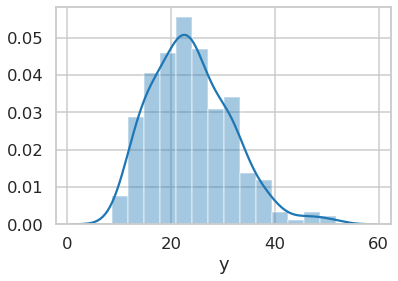

(TODO: describe y variable distribution)

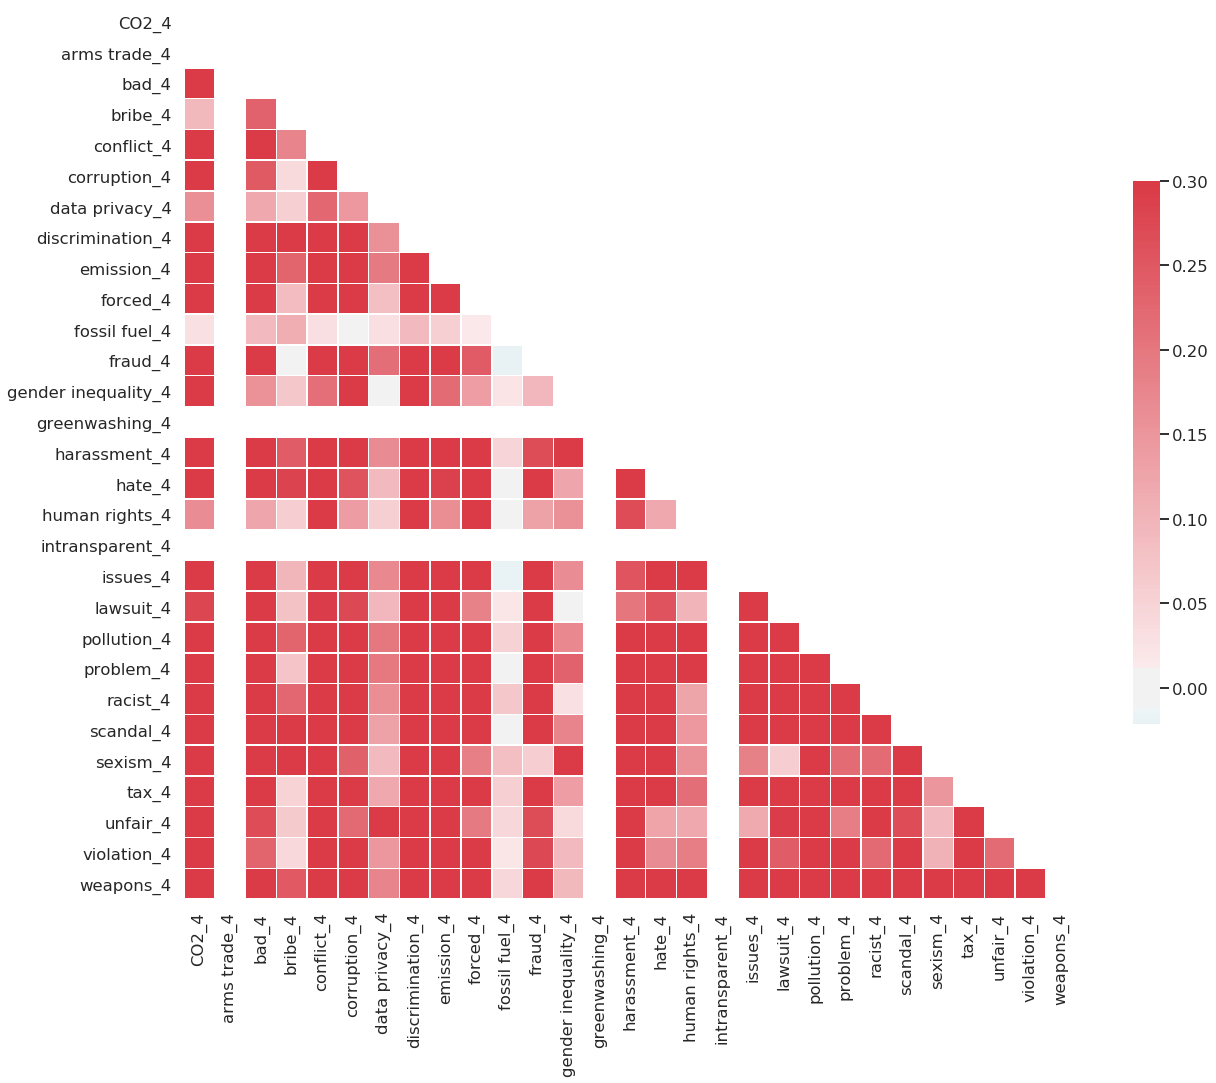

In [351]:
# inspect correlations
corr = df.iloc[:,-29:-1].corr()

# correlation heatmap
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## PCA

In [289]:
# standardize 
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X)

# initialize and compute pca
pca = PCA()
X_pca = pca.fit_transform(X_std)

# get basic info
n_components = len(pca.explained_variance_ratio_)
explained_variance = pca.explained_variance_ratio_
cum_explained_variance = np.cumsum(explained_variance)
idx = np.arange(n_components)+1

df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx).T

mean_explained_variance = df_explained_variance.iloc[:,0].mean() # calculate mean explained variance

# DISPLAY info about PCs
print('Principal components overview')
print('Mean explained variance:', round(mean_explained_variance,3))
print('-'*40)
print(df_explained_variance.head(10))
print('-'*40)

Principal components overview
Mean explained variance: 0.007
----------------------------------------
    explained variance  cumulative
1             0.386840    0.386840
2             0.091858    0.478698
3             0.066203    0.544901
4             0.056188    0.601089
5             0.048013    0.649102
6             0.041028    0.690130
7             0.038532    0.728662
8             0.031079    0.759741
9             0.030355    0.790096
10            0.026619    0.816714
----------------------------------------


Do you want to limit data to Xth component? (y/n) > y
Zoom in onto the first x PC > 5


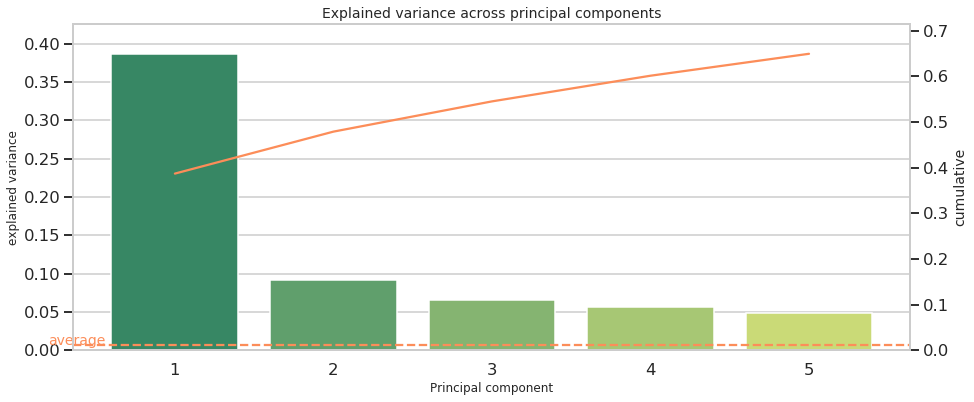

In [416]:
#limit to x PC
limit = input("Do you want to limit data to Xth component? (y/n) > ")
if limit == 'y':
    limit_df = int(input("Zoom in onto the first x PC > "))
else:
    limit_df = len(df_explained_variance)

df_explained_variance_limited = df_explained_variance.iloc[:limit_df,:]

#make scree plot
fig, ax1 = plt.subplots(figsize=(15,6))

ax1.set_title('Explained variance across principal components', fontsize=14)
ax1.set_xlabel('Principal component', fontsize=12)
ax1.set_ylabel('Explained variance', fontsize=12)

ax2 = sns.barplot(x=idx[:limit_df], y='explained variance', data=df_explained_variance_limited, palette='summer')
ax2 = ax1.twinx()
ax2.grid(False)

ax2.set_ylabel('Cumulative', fontsize=14)
ax2 = sns.lineplot(x=idx[:limit_df]-1, y='cumulative', data=df_explained_variance_limited, color='#fc8d59')

ax1.axhline(mean_explained_variance, ls='--', color='#fc8d59') #plot mean
ax1.text(-.8, mean_explained_variance+(mean_explained_variance*.05), "average", color='#fc8d59', fontsize=14) #label y axis

max_y1 = max(df_explained_variance_limited.iloc[:,0])
max_y2 = max(df_explained_variance_limited.iloc[:,1])
ax1.set(ylim=(0, max_y1+max_y1*.1))
ax2.set(ylim=(0, max_y2+max_y2*.1))

plt.show()

In [324]:
df_c = pd.DataFrame(pca.components_, columns=X.keys()).T

In [508]:
print("PC 1 highest and lowest factor loadings")
print('-'*40)
print(df_c.sort_values(by=0).iloc[:,0].head())
print(df_c.sort_values(by=0, ascending=False).iloc[:,0].head(20))

print("\nPC 2 highest and lowest factor loadings")
print('-'*40)
print(df_c.sort_values(by=0).iloc[:,1].head(3))
print(df_c.sort_values(by=0).iloc[:,1].tail(3))

print("\nPC 3 highest and lowest factor loadings")
print('-'*40)
print(df_c.sort_values(by=0).iloc[:,2].head(3))
print(df_c.sort_values(by=0).iloc[:,2].tail(3))

PC 1 highest and lowest factor loadings
----------------------------------------
arms trade_0      -1.110223e-16
greenwashing_1    -0.000000e+00
intransparent_4   -0.000000e+00
greenwashing_0    -0.000000e+00
arms trade_4      -0.000000e+00
Name: 0, dtype: float64
conflict_2          0.122832
conflict_0          0.121809
conflict_1          0.121395
conflict_3          0.120161
conflict_4          0.119546
weapons_2           0.118173
weapons_1           0.117959
weapons_3           0.117439
weapons_0           0.116779
weapons_4           0.115938
discrimination_2    0.112915
discrimination_0    0.112702
discrimination_4    0.112656
discrimination_1    0.112234
discrimination_3    0.112179
scandal_2           0.108660
harassment_0        0.108390
pollution_1         0.107801
harassment_1        0.106869
pollution_4         0.106787
Name: 0, dtype: float64

PC 2 highest and lowest factor loadings
----------------------------------------
arms trade_0      -1.387779e-17
greenwashing_1   

# Create train-test splits (final dataset)

In [464]:
from sklearn.model_selection import train_test_split

# train-test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# merge to distinct train and test data
train = pd.concat([y_train, X_train], axis=1)
test = pd.concat([y_test, X_test], axis=1)

# store as CSV
make_csv(train, 'train.csv', 'data/final', header=False)
make_csv(test, 'test.csv', 'data/final', header=False)

Path created: data/final/train.csv
Path created: data/final/test.csv


# Goals 

The project achieves several goals . 

1. Examine the potential and predictive power Google trends for ESG scores, escpeciallly negative screening. 
2. Engage with APIs to build a dataset from scratch
3. Prepare the data such that it feeds into a model
3. Use Amazon Sagemaker to train, validate, deploy and test a model. 


## Demonstrated skills and learning journey

The project has potential to contribute towards refining ESG investing. I briefly demonstrated the following skills:

1. gather data through APIs from different sources
    1. Google trends: Using the pytrends API at scale and showing a workaround to avoid rate limits which interrupt data collection through errors.
    2. Yahoo! finance: Obtain ESG scores and possibly related financial firm traits
    3. merging data across resources
2. engineer features and re-shape data into a format usable by a model
    1. collapsing time dimension while preserving sequential with a weighting function (exponential decay)
    2. transforming dataframe from long to wide format
    3. creating train and test data for Amazon Sagemaker models
3. Amazon Sagemaker
    1. uploading data to S3 bucket
    2. Use Sagemaker models
    3. Train, deploy and test a Pytorch and linear learner models
4. Model comparison
    1. linear learner vs. Pytorch
    
## Improve the project

Even though, the project has been successful from a learning point of view, several challenges remain ahead and it could be greatly improved. Here is an overview of possible improvements:

1. data collection
    1. gather positive criteria to avoid high correlation among negative screening criteria
    2. add more firm traits, such as financial indicators, sector or region 
    3. include other ESG related data from resources other than Yahoo! finance, such as CSRhub.com
    4. add more firms to increase informational value for model learning 
2. experiment with other shorter versus longer time intervals to compare informational value
3. Get closer to industry standard: 
    1. refactor and modularize code
    3. set up and rely on unit tests
3. further model testing:apply model to firms that lack ESG scores, but have all other information available